# python launcher

In [1]:
import sys
if 'ipykernel_launcher.py' not in sys.argv[0]:
    manual = False
    scenario = sys.argv[1]
else:
    manual = True
    scenario = 'ref_18'
    %matplotlib inline

In [2]:
#%matplotlib inline

In [3]:
import pandas as pd

# import 

In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np

work_path = r'../../../'
quetzal_path = work_path + r'quetzal_santo_domingo/'

import sys
sys.path.insert(0, '../../../quetzal/')

from quetzal.model import stepmodel
from quetzal.io import display

SQLalchemy is not installed. No support for SQL output.


In [5]:
distributed =  stepmodel.read_zip(quetzal_path + 'model/transport/distribution.zip')

zones: 100%|██████████| 4/4 [00:00<00:00, 63.82it/s]


In [6]:
car =  stepmodel.read_zip(quetzal_path + 'model/transport/car_pathfinder.zip')
pt = stepmodel.read_zip(quetzal_path + 'model/'+ scenario +'/pt_pathfinder.zip')

zones: 100%|██████████| 26/26 [00:02<00:00,  9.65it/s]       


In [7]:
sm = pt.copy()
sm.car_los = car.car_los

sm.road_nodes = car.road_nodes
sm.road_links = car.road_links

In [8]:
sm.volumes = distributed.volumes

# prep

In [9]:
self = sm
for value in ['length']:
    value_dict = self.road_links[value].to_dict()
    self.car_los[value] = self.car_los['link_path'].apply(
        lambda p: sum([value_dict[l] for l in p])
    ) 

# Utility parameters

In [10]:
parameter_frame = pd.read_excel(quetzal_path + r'inputs/parametros.xlsx').set_index(['category','parameter'])
for c in parameter_frame.columns:
    parent = parameter_frame[c][('general', 'parent')]
    try:
        parent = parent.iloc[0]
    except AttributeError:# 'str' object has no attribute 'iloc'
        pass
    parameter_frame[c] = parameter_frame[c].fillna(parameter_frame[parent])
var = parameter_frame[scenario]

year = int(var['general', 'year'])

# volumes

In [11]:
if var['general','freeze_distribution'].iloc[0].lower() == 'true':
    sm.volumes['car'] = sm.volumes['survey_car']
    sm.volumes['nocar'] = sm.volumes['survey_pt'] + sm.volumes['survey_walk']
    delta = year - 2018
    for segment in ['car', 'nocar']:
        sm.volumes[segment] = sm.volumes[segment]  * np.power(sm.volumes['growth'], delta)
else :
    sm.volumes[['car', 'nocar']] = sm.volumes[['car' + str(year), 'nocar' + str(year)]]

In [12]:
car_speed = float(var['speed']['car'])
gas_per_km = float(var['general']['gas_per_km']) # gal US per km (1 US gal= 3.7L)
gas_price = float(var['general']['gas_price'])# DOP per gal US
price_per_m =  gas_per_km * gas_price / 1000

# Fares

## PT fares

In [13]:
fare_attributes = pd.DataFrame(
    {
    'price': var['price'],
    'transfers': var['transfers']
    }
)
fare_attributes.index.name = 'fare_id'
fare_attributes.reset_index(inplace=True)
fare_attributes[['price', 'transfers']] = fare_attributes[['price', 'transfers']].astype(float)
fare_attributes.loc[fare_attributes['fare_id'] == 'integrated', 'transfers'] = np.inf
fare_attributes

,fare_id,price,transfers
0,bus,15.0,0.0
1,concho,25.0,0.0
2,express_bus,20.0,0.0
3,integrated,20.0,inf
4,minibus,25.0,0.0
5,tram,20.0,0.0


In [14]:
left = var['fare_id'].reset_index()
left.columns = ['route_type', 'fare_id']
left

,route_type,fare_id
0,concho,concho
1,minibus,minibus
2,subway,integrated
3,express_bus,integrated
4,gondola,integrated
5,bus,bus
6,tram,integrated


In [15]:
left

,route_type,fare_id
0,concho,concho
1,minibus,minibus
2,subway,integrated
3,express_bus,integrated
4,gondola,integrated
5,bus,bus
6,tram,integrated


In [16]:
right = pt.lines[['route_type', 'route_id']]

In [17]:
fare_rules = pd.merge(left, right)[['fare_id', 'route_id']]
fare_rules.head()

,fare_id,route_id
0,concho,CP_C100_1
1,concho,CP_C100_2
2,concho,CP_C101E_1
3,concho,CP_C101E_2
4,concho,CP_C102_1


In [18]:
fare_attributes['agency_id'] = 'intrant'

In [19]:
sm.links['agency_id'] = 'intrant'
sm.nodes['zone_id'] = 0

In [20]:
sm.fare_rules = fare_rules
sm.fare_attributes = fare_attributes
sm.compute_arod_list()
sm.analysis_pt_fare(od_fares=False)

## car fares

In [21]:
# length
self = sm
sm.road_links['toll'] = 0

In [22]:
self.car_los['price'] = self.car_los['length'] * price_per_m #+ self.car_los['toll']

# Time

## walk_time

In [23]:
short_leg_speed = float(var['general']['short_leg_speed'])
long_leg_speed = float(var['general']['long_leg_speed'])
threshold= float(var['general']['ntleg_threshold'])
footpath_speed= float(var['general']['footpath_speed'])
n_ntlegs = int(var['general']['n_ntlegs'])

In [24]:
sm.footpaths['time'] = sm.footpaths['length']  / 1000 * 3600 / footpath_speed
#sm.zone_to_transit['time'] = sm.zone_to_transit['distance']  / 1000 * 3600 / short_leg_speed
#sm.zone_to_road['time'] = sm.zone_to_road['distance']  / 1000 * 3600 / short_leg_speed

In [25]:
sm.preparation_ntlegs(
    n_ntlegs=n_ntlegs,
    short_leg_speed=short_leg_speed,
    long_leg_speed=long_leg_speed,
    zone_to_road=True,
)

## car_time

In [26]:
sm.road_links['speed'] = car_speed
sm.road_links['time'] = sm.road_links['length'] / 1000 * 3600 / sm.road_links['speed']

In [27]:
sm.zone_to_road  = car.zone_to_road

In [28]:
sm.analysis_car_time()
sm.analysis_car_length()

## pt_time

In [29]:
from shapely import geometry
def straight_length(ls):
    return geometry.LineString([list(ls.coords)[0],  list(ls.coords)[-1]]).length

In [30]:
sm.links['length'] = sm.links['geometry'].apply(straight_length)

In [31]:
if False:
    sm.links['speed'] = link_speed
    sm.links.loc[sm.links['route_type'] == 'subway', 'speed'] = metro_speed
    sm.links['time'] =  sm.links['length'] / 1000 * 3600 / sm.links['speed']

In [32]:
sm.analysis_pt_time(boarding_time=0)
sm.analysis_pt_length()

# transfers

In [33]:
sm.car_los['ntransfers'] = 0
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(len)

# route_types

In [34]:
mode_hierarchy = ['car', 'subway', 'tram',  'gondola', 'express_bus', 'bus', 'minibus', 'concho', 'walk']

In [35]:
sm.los = sm.pt_los
sm.analysis_pt_route_type(hierarchy=mode_hierarchy)
sm.analysis_car_route_type()

In [36]:
sm.lighten_pt_los()
sm.analysis_pt_los()
sm.lighten_car_los()
sm.analysis_car_los()
sm.los = pd.concat([sm.car_los, sm.pt_los]).reset_index(drop=True)

path_analysis: 100%|██████████| 134505/134505 [00:03<00:00, 35986.35it/s]


In [37]:
#sm.los.dropna(axis=1, inplace=True)

# UTILITY

In [38]:
loc = (sm.los['route_type'] == 'walk') & (sm.los['time'] > 1800)
sm.los.loc[loc, 'price'] = 100

In [39]:
route_types = set(sm.links['route_type'].unique()).union({'car', 'walk'})

In [40]:
# Average
sm.preparation_logit(
    mode=1, 
    pt_mode=0.5, 
    pt_path=0.2, 
    time=-1 / 3600,
    price= -1 / 50,
    transfers=-0.2,
    segments=['car', 'nocar'],
)

In [41]:
sm.mode_utility[['car', 'nocar']] = 0
sm.mode_utility.loc[['car'], ['nocar', 'car']] = [-100, 0.5] # [-100, 0] 
sm.mode_utility.loc[['minibus', 'concho'], ['nocar', 'car']] = 0

if var['general','freeze_modal_split'].iloc[0].lower() == 'true':
    sm.mode_utility.loc[['car'], ['nocar', 'car']] = [-100, 100] # [-100, 0] 

In [42]:
sm.mode_utility -= sm.mode_utility.max()

In [43]:
sm.logit_scales
sm.mode_utility

segment,root,car,nocar
route_type,,,
subway,0.0,-0.5,0.0
car,0.0,0.0,-100.0
root,0.0,-0.5,0.0
walk,0.0,-0.5,0.0
bus,0.0,-0.5,0.0
minibus,0.0,-0.5,0.0
concho,0.0,-0.5,0.0
gondola,0.0,-0.5,0.0


In [44]:
sm.utility_values.loc['time', 'car'] = sm.utility_values.loc['time', 'nocar'] * 2

# here

In [45]:
sm.los.reset_index(drop=True, inplace=True)

In [46]:
sm.los['index'] = sm.los.index

# utility

In [47]:
sm.analysis_mode_utility(how='min', segment='car')
sm.analysis_mode_utility(how='min', segment='nocar')

In [48]:
sm.initialize_logit()

In [49]:
sm.segments = ['car', 'nocar']

In [50]:
sm.logit_scales['nocar'] = sm.logit_scales['car']

In [51]:
sm.logit_scales

segment,root,car,nocar
route_type,,,
subway,0.2,0.2,0.2
car,0.0,0.0,0.0
root,1.0,1.0,1.0
walk,0.0,0.0,0.0
bus,0.2,0.2,0.2
minibus,0.2,0.2,0.2
concho,0.2,0.2,0.2
gondola,0.2,0.2,0.2
pt,0.5,0.5,0.5


In [52]:
sm.step_logit(nchunks=5)

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


In [53]:
sm.od_probabilities = sm.probabilities.set_index(
    ['origin', 'destination', 'segment']
).unstack('segment').swaplevel(axis='columns')
sm.od_utilities = sm.utilities.set_index(
    ['origin', 'destination', 'segment']
).unstack('segment').swaplevel(axis='columns')

In [54]:
sm.od_probabilities

segment              car nocar       car     nocar       car         nocar  \
route_type          root  root      walk      walk       car           car   
origin  destination                                                          
zone_1  zone_1         1     1  0.500000  1.000000  0.500000  3.720076e-44   
        zone_10        1     1  0.004110  0.040362  0.728461  3.723817e-44   
        zone_101       1     1  0.000006  0.001447  0.564831  1.589025e-44   
        zone_102       1     1  0.001397  0.028268  0.744540  4.038176e-44   
        zone_103       1     1  0.007370  0.040586  0.611358  2.554357e-44   
...                  ...   ...       ...       ...       ...           ...   
zone_98 zone_94        1     1  0.472009  0.798752  0.467653  2.496417e-44   
        zone_95        1     1  0.020224  0.067039  0.695159  3.116551e-44   
        zone_96        1     1  0.017829  0.082926  0.786247  4.221345e-44   
        zone_97        1     1  0.030232  0.128753  0.798559  5.986740e-44   
        zone_98        1     1  0.500000  1.000000  0.500000  3.720076e-44   

segment                   car     nocar     car   nocar       car     nocar  \
route_type                 pt        pt gondola gondola    concho    concho   
origin  destination                                                           
zone_1  zone_1       0.000000  0.000000     0.0     0.0  0.000000  0.000000   
        zone_10      0.267428  0.959638     0.0     0.0  0.002588  0.009832   
        zone_101     0.435163  0.998553     0.0     0.0  0.003541  0.012578   
        zone_102     0.254063  0.971732     0.0     0.0  0.032002  0.111095   
        zone_103     0.381272  0.959414     0.0     0.0  0.045879  0.129862   
...                       ...       ...     ...     ...       ...       ...   
zone_98 zone_94      0.060339  0.201248     0.0     0.0  0.060339  0.201248   
        zone_95      0.284617  0.932961     0.0     0.0  0.122695  0.328892   
        zone_96      0.195924  0.917074     0.0     0.0  0.046635  0.147516   
        zone_97      0.171209  0.871247     0.0     0.0  0.011386  0.101965   
        zone_98      0.000000  0.000000     0.0     0.0  0.000000  0.000000   

segment                   car     nocar       car     nocar       car  \
route_type            minibus   minibus       bus       bus    subway   
origin  destination                                                     
zone_1  zone_1       0.000000  0.000000  0.000000  0.000000  0.000000   
        zone_10      0.076434  0.248804  0.188407  0.701002  0.000000   
        zone_101     0.018832  0.067003  0.068776  0.552871  0.344014   
        zone_102     0.073109  0.294369  0.148952  0.566268  0.000000   
        zone_103     0.131212  0.385000  0.204181  0.444553  0.000000   
...                       ...       ...       ...       ...       ...   
zone_98 zone_94      0.000000  0.000000  0.000000  0.000000  0.000000   
        zone_95      0.114820  0.318163  0.047102  0.285906  0.000000   
        zone_96      0.035217  0.128190  0.114072  0.641368  0.000000   
        zone_97      0.159823  0.769282  0.000000  0.000000  0.000000   
        zone_98      0.000000  0.000000  0.000000  0.000000  0.000000   

segment                 nocar  
route_type             subway  
origin  destination            
zone_1  zone_1       0.000000  
        zone_10      0.000000  
        zone_101     0.366102  
        zone_102     0.000000  
        zone_103     0.000000  
...                       ...  
zone_98 zone_94      0.000000  
        zone_95      0.000000  
        zone_96      0.000000  
        zone_97      0.000000  
        zone_98      0.000000  

[15625 rows x 18 columns]

In [55]:
t = sm.los['path'].apply(tuple)

# Control

In [56]:
if manual:
    %matplotlib inline

In [57]:
sm.volumes = distributed.volumes.copy()
#sm.volumes.loc[sm.volumes['origin'] == sm.volumes['destination'], ['car', 'nocar']] = 0 

In [58]:
sm.od = sm.volumes.set_index(['origin', 'destination'])[['car', 'nocar']] 

In [59]:
sm.probabilities

route_type,origin,destination,segment,root,walk,car,pt,gondola,concho,minibus,bus,subway
0,zone_1,zone_1,car,1,0.500000,5.000000e-01,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,zone_1,zone_1,nocar,1,1.000000,3.720076e-44,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,zone_1,zone_10,car,1,0.004110,7.284614e-01,0.267428,0.0,0.002588,0.076434,0.188407,0.000000
3,zone_1,zone_10,nocar,1,0.040362,3.723817e-44,0.959638,0.0,0.009832,0.248804,0.701002,0.000000
4,zone_1,zone_101,car,1,0.000006,5.648308e-01,0.435163,0.0,0.003541,0.018832,0.068776,0.344014
...,...,...,...,...,...,...,...,...,...,...,...,...
6245,zone_98,zone_96,nocar,1,0.082926,4.221345e-44,0.917074,0.0,0.147516,0.128190,0.641368,0.000000
6246,zone_98,zone_97,car,1,0.030232,7.985589e-01,0.171209,0.0,0.011386,0.159823,0.000000,0.000000
6247,zone_98,zone_97,nocar,1,0.128753,5.986740e-44,0.871247,0.0,0.101965,0.769282,0.000000,0.000000
6248,zone_98,zone_98,car,1,0.500000,5.000000e-01,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [60]:
a = sm.od_probabilities.copy()
a.columns = pd.MultiIndex.from_tuples(a.columns)

In [61]:
voy = a['car'].apply(lambda c: c * sm.od['car']) + a['nocar'].apply(lambda c: c * sm.od['nocar']) 

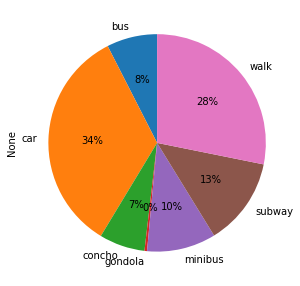

In [62]:
voykil = voy.apply(
    lambda c: c * distributed.euclidean.set_index(
    ['origin', 'destination']).sort_index()['km']
)


s = voy.sum()[sorted(set(sm.mode_nests.index) - set(sm.mode_nests['root']))]
plot = s.plot(
    kind='pie', 
    autopct='%1.0f%%',
    shadow=False,
    startangle=90, figsize=[5, 5])
plot.set_aspect('equal')

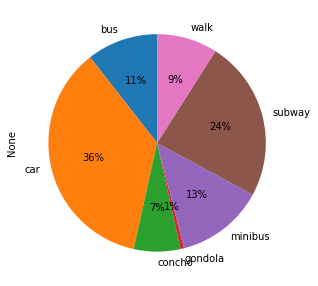

In [63]:
s = voykil.sum()[sorted(set(sm.mode_nests.index) - set(sm.mode_nests['root']))]
plot = s.plot(
    kind='pie', 
    autopct='%1.0f%%',
    shadow=False,
    startangle=90, figsize=[5, 5])
plot.set_aspect('equal')

In [64]:
s = voykil.sum()[sorted(set(sm.mode_nests.index) - set(sm.mode_nests['root']))]

# Assignment

In [65]:
sm.car_los['path'] = sm.car_los['path'].apply(tuple)
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.los['path'] = sm.los['path'].apply(tuple)

## PT

# segmented assignment

In [74]:
sm.step_assignment(boarding_links=True, alightings=True, transfers=True, road=True, segmented=False)

In [75]:
sm.road_links.loc[53982]

index                                                        53982
a                                              osm_node_1864096701
b                                              osm_node_2295336584
length                                                   47.330829
geometry         LINESTRING (393513.6355091452 2047148.77479883...
capacity                                                      5000
time                                                     11.359399
toll                                                             0
speed                                                         15.0
(volume, car)                                          3012.652035
(volume, pt)                                           7406.847634
volume                                                 7406.847634
Name: 53982, dtype: object

In [76]:
links = sm.links#.loc[sm.links['route_type'] == 'subway']
links = sm.links.loc[sm.links['volume'] > 0]
links['label'] = ''

In [77]:
links['volume'].max()

11387.308810953256

In [70]:
sm.road_links['volume'] = sm.road_links[('volume', 'pt')]

In [71]:
df = sm.links
df = df.loc[df['volume'] > 0]

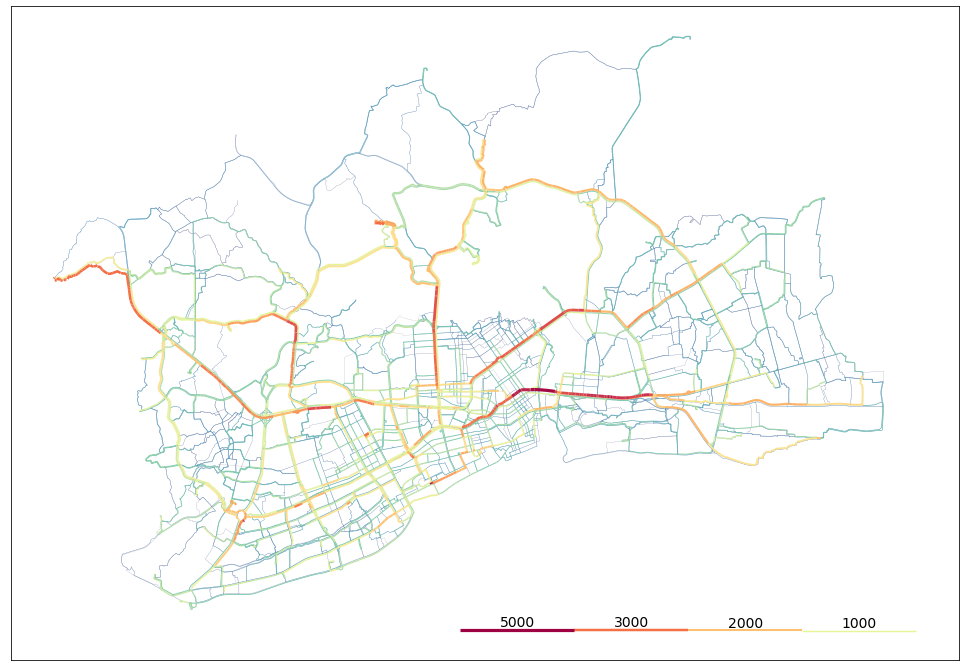

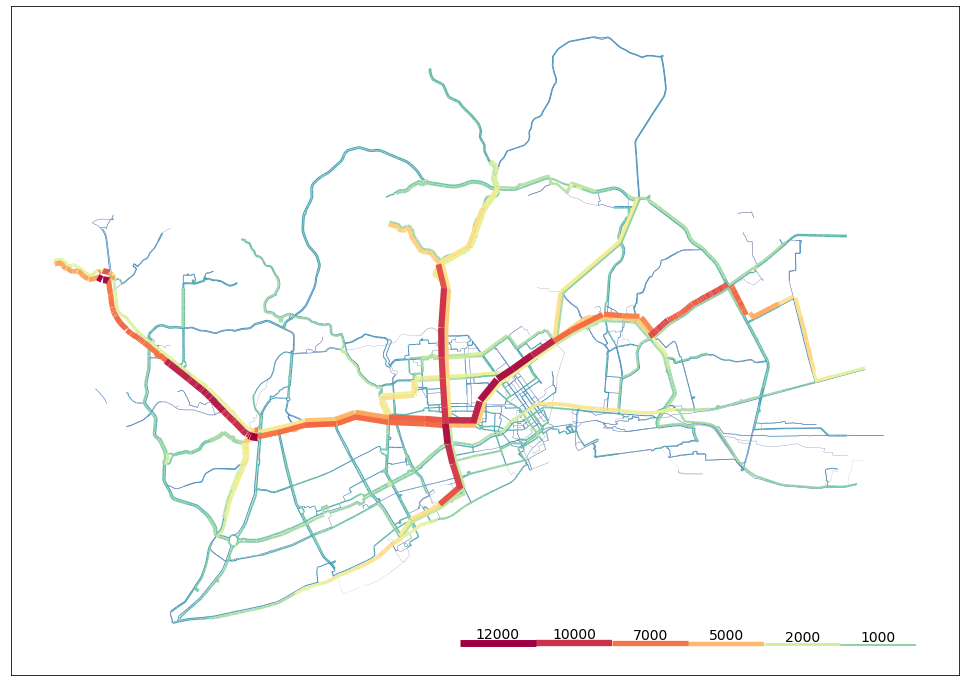

In [72]:
if manual:
    import matplotlib.pyplot as plt
    from syspy.syspy_utils import data_visualization as dv
    spectral = list(reversed(
        ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b',
         '#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']))

    fig, ax = plt.subplots(figsize=[17, 15])
    lv = (5000,3000, 2000, 1000)
    df = sm.road_links
    df['volume'] = df[('volume', 'car')]
    df = df.dropna(subset=['volume'])

    plot = dv.bandwidth(
        df, value_column='volume', power=0.5, max_value=lv[0], legend_values=lv,
        legend_length=0.5, label_column='label', max_linewidth_meters=100,
        cmap=spectral,
        label_kwargs={'size':14, 'color':'black'}, ax=ax
    )

    lv = (12000,10000, 7000,5000, 2000, 1000)
    fig, ax = plt.subplots(figsize=[17, 15])
    infra_links = sm.links.loc[sm.links.road_length.isnull()]

    sm.road_links['volume'] = sm.road_links[('volume', 'pt')]
    df = pd.concat([infra_links, sm.road_links])
    df['volume'] = df['volume'].fillna(0)
    df = df.loc[df['volume'] > 0]

    plot = dv.bandwidth(
        df, value_column='volume', power=0.5, max_value=lv[0],legend_values=lv,
        legend_length=0.5, label_column='label', max_linewidth_meters=200,
        #geographical_bounds=list(raster_montreal.bounds),
        cmap=spectral,
        label_kwargs={'size':14, 'color':'black'}, ax=ax
    )

In [73]:
sm.pt_los = sm.los.loc[sm.los['route_type'] != 'car']
sm.to_zip(quetzal_path + 'model/' +scenario + '/assigned.zip', omitted_attributes=['pt_los', 'car_los'])

od: 100%|██████████| 35/35 [00:09<00:00,  3.62it/s]                       
